## **ViT 전처리 과정**
### 과정
- 이미지 로드 및 크기 조정
- 텐서로 변환
- 패치 생성
 - 이미지를 작은 패치로 분할
 - ex) 32x32 크기의 이미지를 4x4 크기의 패치로 나누면 8x8=64개의 패치 생성
- Linear Projection
 - 각 패치를 임베딩 벡터로 변환
 - 각 패치(4x4)의 픽셀 값을 펼쳐서 1차원 벡터로 만든 후, 이를 고차원 공간(예: 64차원)으로 변환
- Positional Embedding 추가
 - 패치의 위치 정보를 추가
 - Transformer 모델이 순서를 인식 X 따라서 패치의 순서 정보를 저장해줘야함

### Input & Output
 - Input
  - 32x32 크기의 이미지
 - Output
  - [배치 크기, 패치 수, 임베딩 차원] 형태의 텐서
  - ex) 배치 크기가 1이고, 패치 수가 64 (32x32 이미지를 4x4 패치로 나누면 8x8 = 64 패치), 임베딩 차원이 64인 텐서

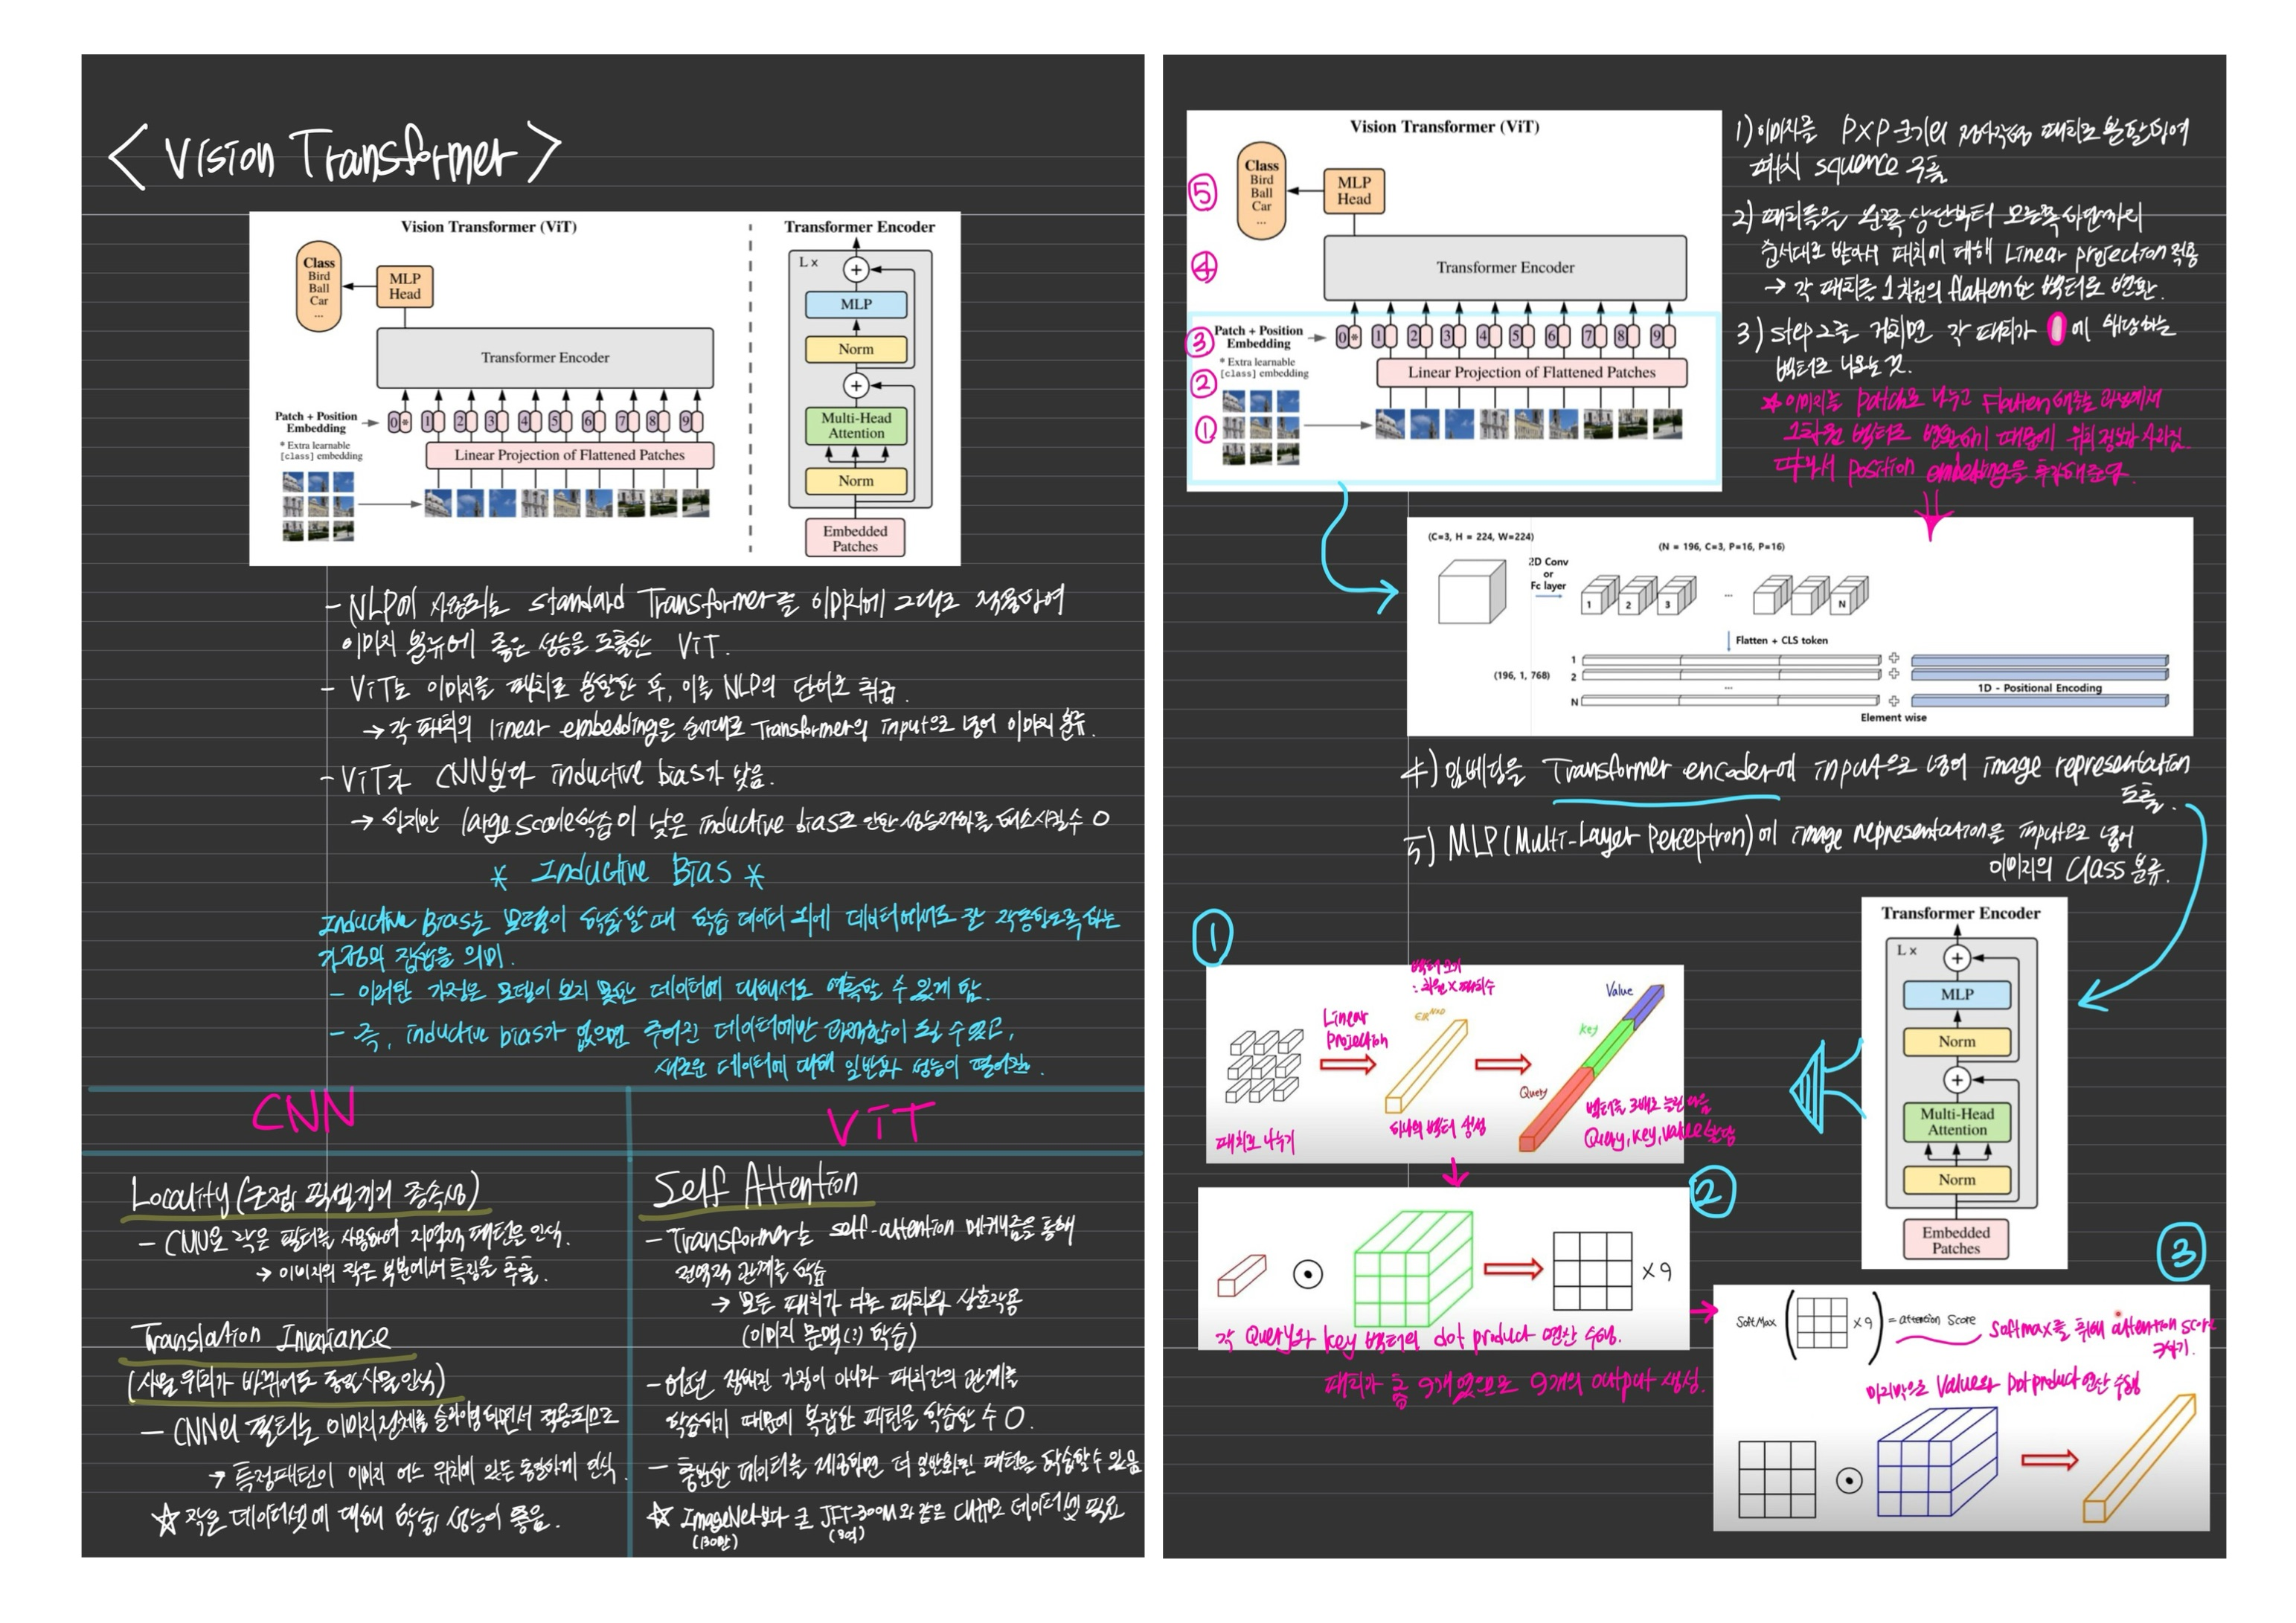

## **CNN 전처리 과정**
### 과정
- 이미지 로드 및 크기 조정
- 텐서로 변환
- 이미지 정규화
 - 각 채널(RGB)의 픽셀 값을 평균과 표준편차를 사용하여 정규화
 - 이미지 데이터를 특정 범위로 조정하여 학습을 안정화하고 속도를 높이기 위함

### Input & Output
- Input
 - 32x32 크기의 이미지
- Output
 - [배치 크기, 채널 수, 높이, 너비] 형태의 텐서
 - ex) 배치 크기가 1이고, 채널 수가 3 (RGB), 높이와 너비가 각각 32인 텐서

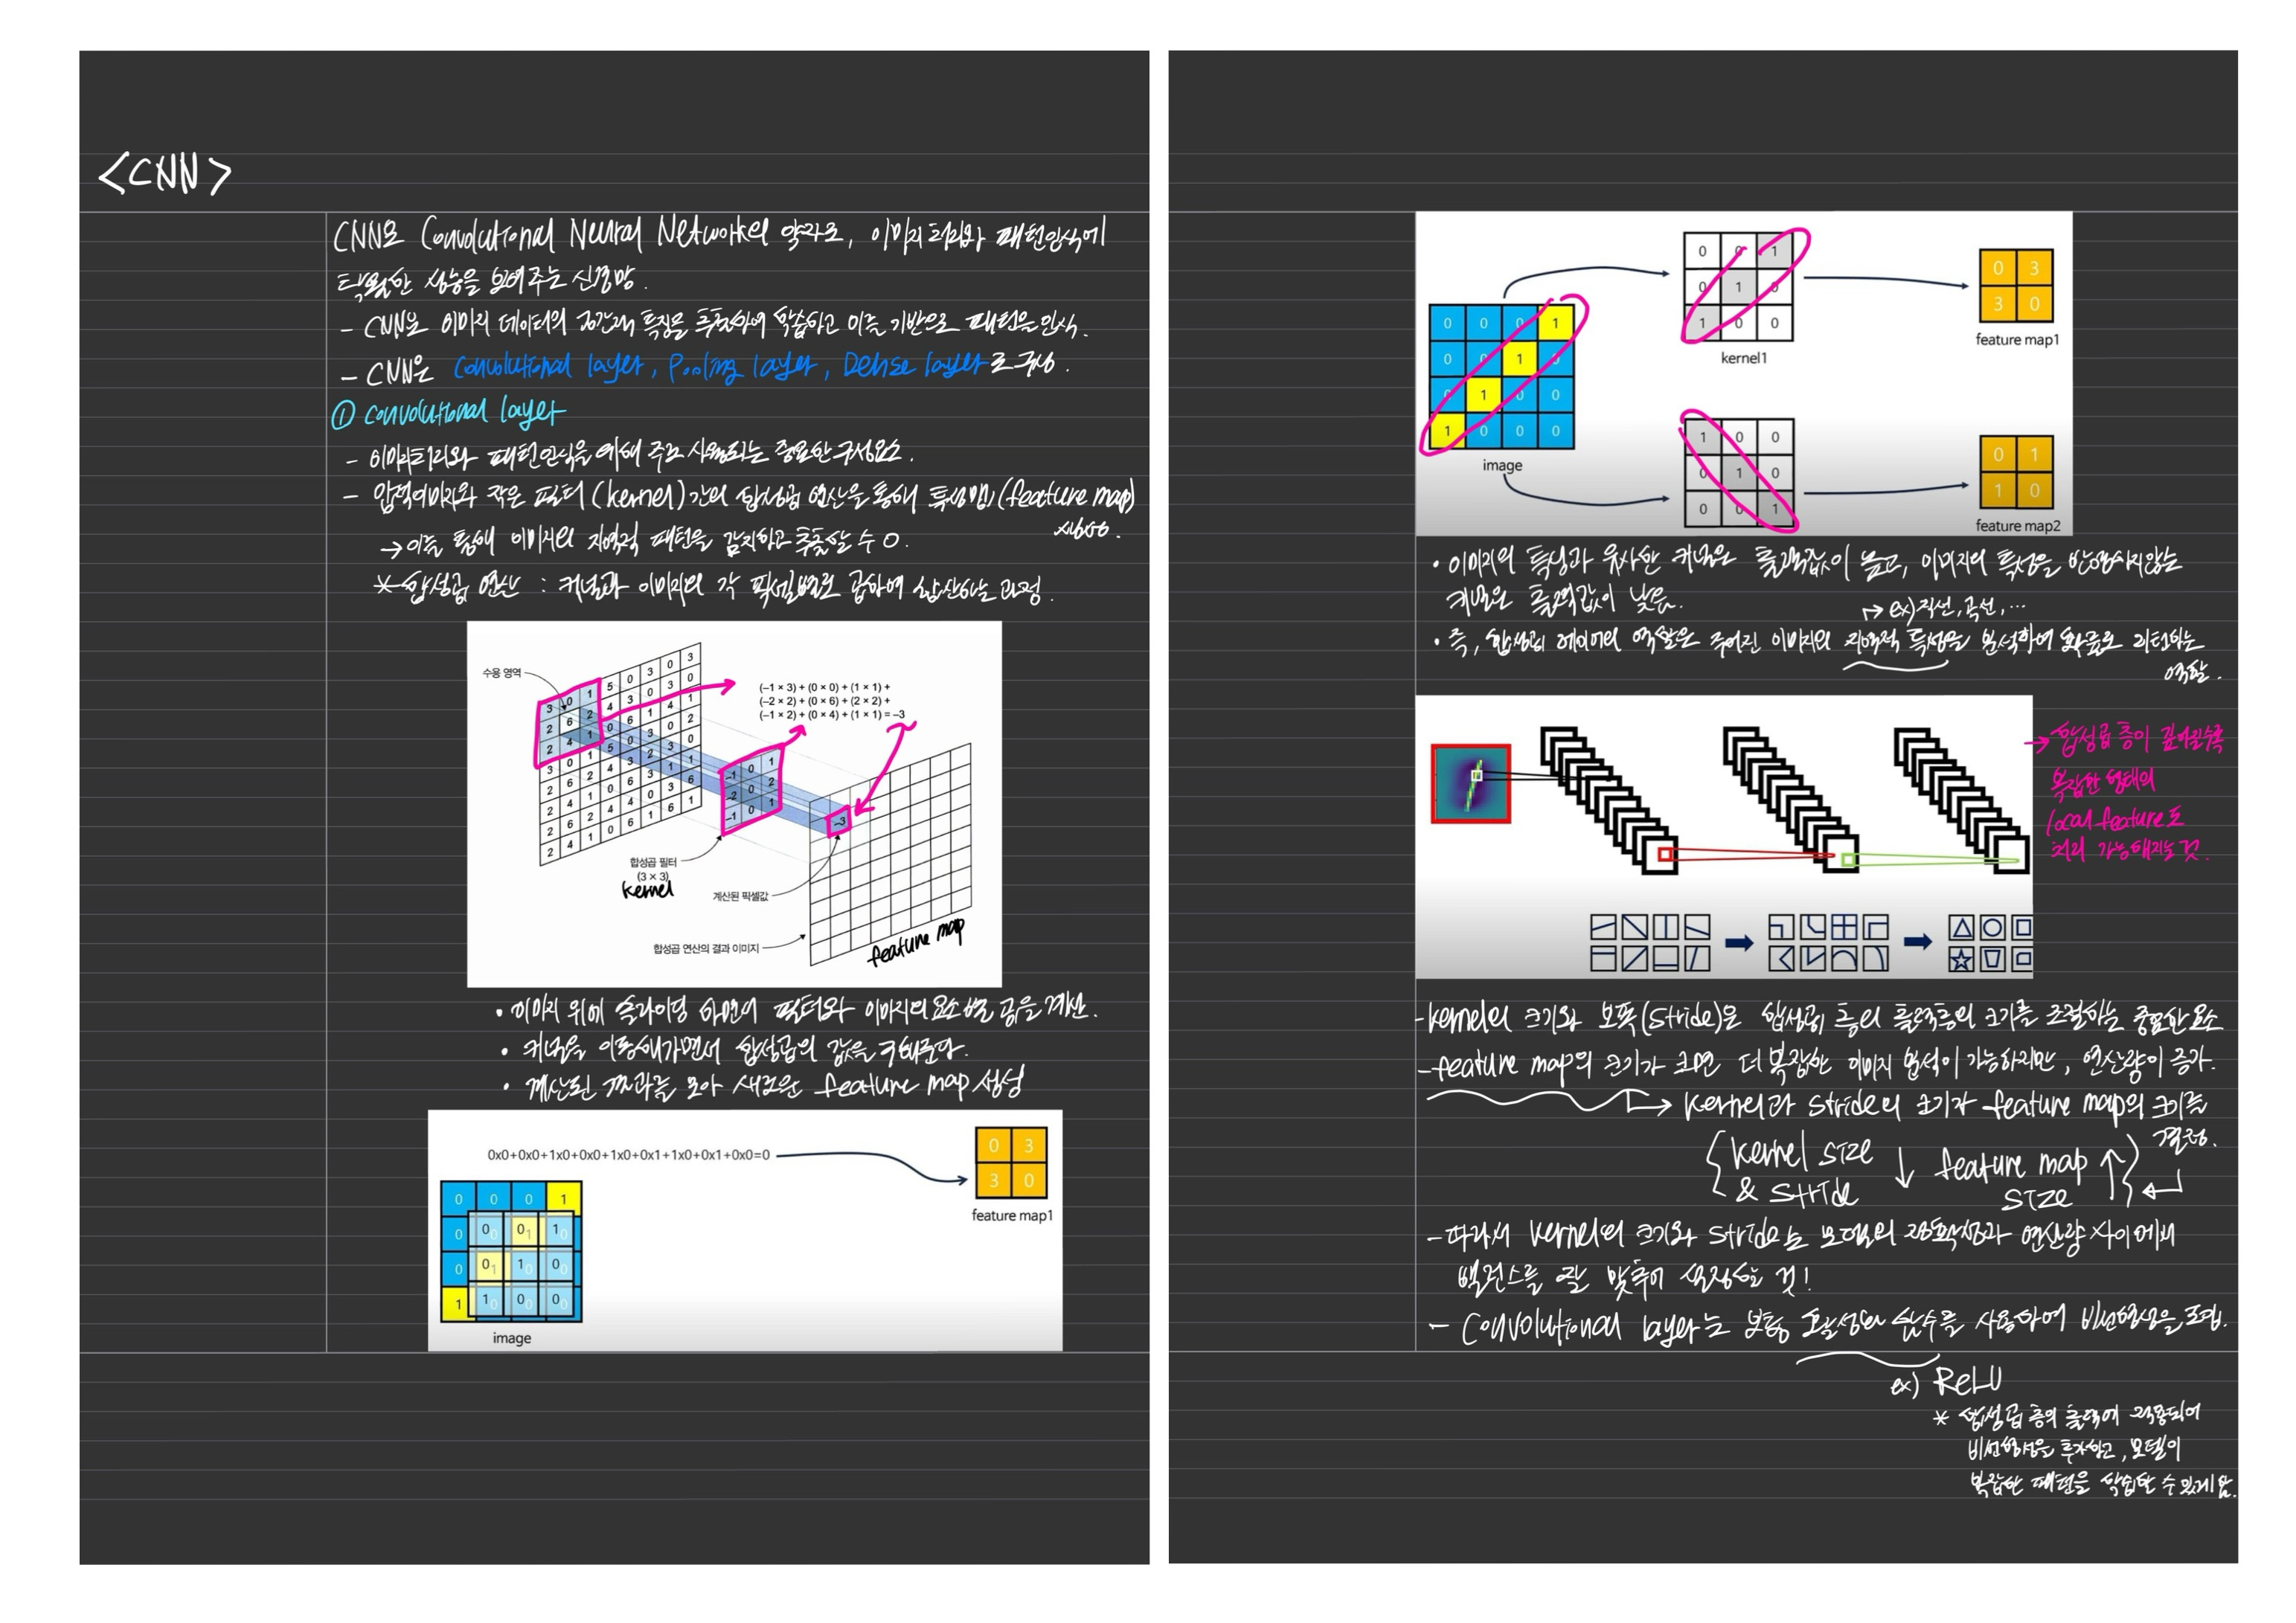

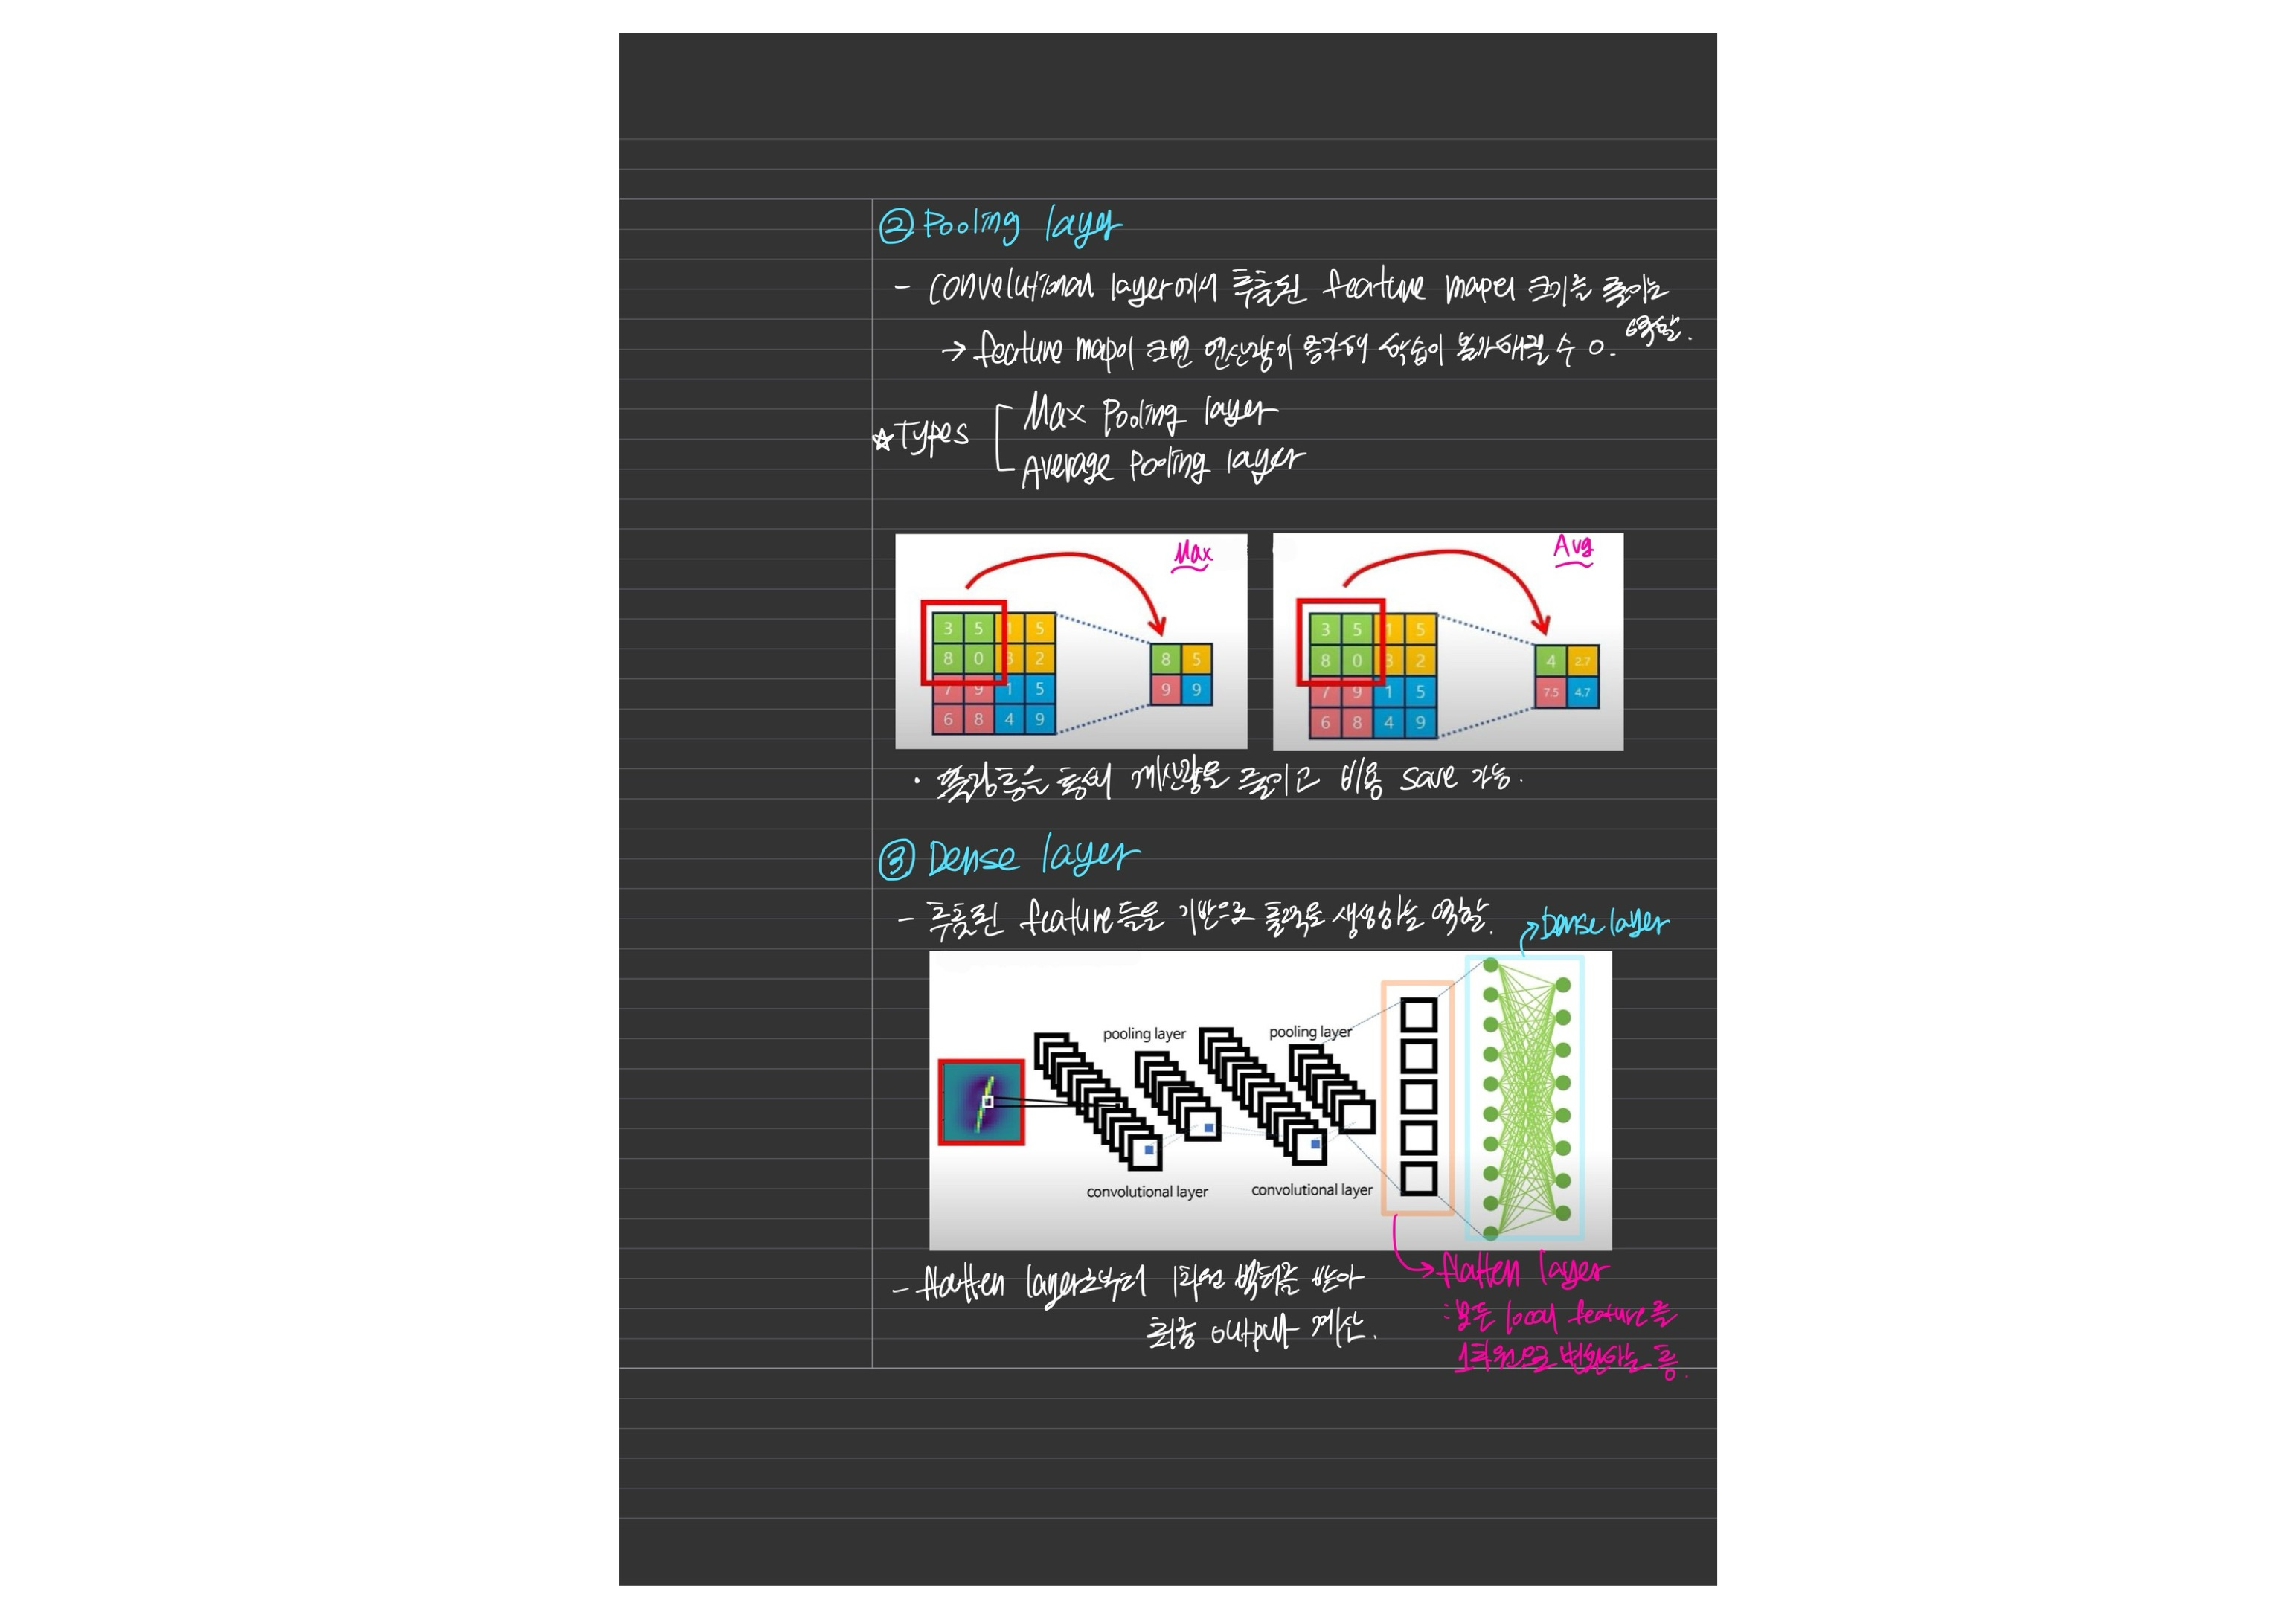

### 1) 이미지 로딩 및 크기 조정

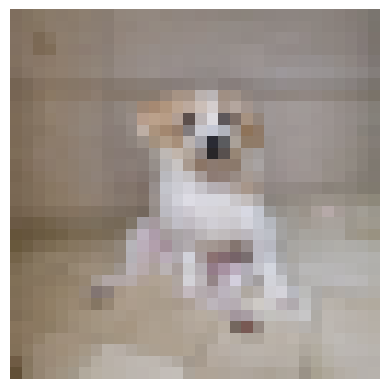

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/test/3/image_for_preprocess.jpg'

image = Image.open(image_path)

# 이미지를 32x32 크기로 조정
image = image.resize((32, 32))

plt.imshow(image)
plt.axis('off')
plt.show()

### 2) 텐서 변환

In [6]:
import torchvision.transforms as transforms

'''이미지를 텐서로 변환-> 픽셀 값 [0, 1] 범위로 스케일일
unsqueeze(0)을 사용하여 배치 차원을 추가, CNN 모델은 일반적으로 배치 차원을 포함한 4차원 텐서(배치 크기, 채널 수, 높이, 너비)를 입력으로 받음'''

transform_to_tensor = transforms.Compose([
    transforms.ToTensor()  # 이미지를 텐서로 변환
])

image_tensor = transform_to_tensor(image).unsqueeze(0)  # 배치 차원을 추가
print("Transformed Image Shape:", image_tensor.shape)


Transformed Image Shape: torch.Size([1, 3, 32, 32])


### 3) ViT 전처리

In [7]:
# ViT 전처리 함수
def create_patches(image, patch_size=4):
    B, C, H, W = image.size()
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, -1, patch_size * patch_size)
    patches = patches.permute(0, 2, 1, 3)
    patches = patches.reshape(B, -1, C * patch_size * patch_size)
    return patches

def add_positional_embedding(x, num_patches, d_k):
    positional_embedding = torch.randn(1, num_patches, d_k)
    return x + positional_embedding

def preprocess_vit(image, patch_size=4, d_k=64):
    B, C, H, W = image.size()
    num_patches = (H // patch_size) * (W // patch_size)
    patches = create_patches(image, patch_size)
    linear_proj = nn.Linear(patch_size * patch_size * C, d_k)
    x = linear_proj(patches)
    x = add_positional_embedding(x, num_patches, d_k)
    return x

# ViT 전처리 실행
patch_size = 4
d_k = 64
vit_patches = preprocess_vit(image_tensor, patch_size, d_k)
print("ViT Preprocessed Patches Shape:", vit_patches.shape)  # (배치 크기, 패치 수, 임베딩 차원)

ViT Preprocessed Patches Shape: torch.Size([1, 64, 64])


### 3) CNN 전처리

In [8]:
# 이미지를 정규화하는 변환 정의
'''각 채널(R, G, B)의 평균과 표준편차를 사용하여 이미지를 정규화
평균과 표준편차 값은 일반적으로 ImageNet 데이터셋의 통계치를 사용
정규화 과정은 픽셀 값에서 평균을 빼고, 표준편차로 나누는 과정을 통해 각 채널의 값을 정규화'''

transform_normalize = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화
])

cnn_tensor = transform_normalize(image).unsqueeze(0)  # 배치 차원을 추가
print("CNN Preprocessed Image Shape:", cnn_tensor.shape)


CNN Preprocessed Image Shape: torch.Size([1, 3, 32, 32])
